## New Coders Survey 2016

An exploration of the dataset from the Free Code Camp survey: https://github.com/FreeCodeCamp/2016-new-coder-survey

In [1]:
from __future__ import division
from collections import defaultdict
import re
import json

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
sns.set(font_scale=1.25)

<hr>

### Load Data, Column Overview

Read data to DataFrame

In [4]:
df = pd.read_csv('data/2016-FCC-New-Coders-Survey-Data.csv', low_memory=False)
print len(df), 'rows'
print len(df.columns), 'columns'

15620 rows
113 columns


There are a large number of data columns... the column names follow a simple convention, so we can parse and pretty print for an overview.

In [5]:
def parse_header(header):
    """Split by uppercase, maxsplit 1."""
    return [part for part in re.split(r'([A-Z][a-z]*)', header, 1) 
            if part]

def cols_to_tree(cols):
    """Build simple tree from column names."""
    tree = defaultdict(list)
    for col in cols:
        parts = parse_header(col)
        if len(parts) > 1:
            fst, rest = parts
        else:
            fst, rest = parts[0], ''
        tree[fst].append(rest)      
    return tree

In [6]:
def pretty_print(key, vals, vals_len):
    """Pretty print dict in compact fashion."""
    vals_str = ', '.join(vals)
    vals_str_split = ['\t' + vals_str[i: i+vals_len]
                      for i in xrange(0, len(vals_str), vals_len)]
    print '>', key, '\n', '\n'.join(vals_str_split)
    
cols_tree = cols_to_tree(df.columns)
for key in sorted(cols_tree):
    vals =  cols_tree[key]
    pretty_print(key, vals, 100)

> Age 

> Attended 
	Bootcamp
> Bootcamp 
	Finish, FullJobAfter, LoanYesNo, MonthsAgo, Name, PostSalary, Recommend
> Children 
	Number
> City 
	Population
> Code 
	EventBootcamp, EventCoffee, EventConferences, EventDjangoGirls, EventGameJam, EventGirlDev, EventHac
	kathons, EventMeetup, EventNodeSchool, EventNone, EventOther, EventRailsBridge, EventRailsGirls, Eve
	ntStartUpWknd, EventWomenCode, EventWorkshop
> Commute 
	Time
> Country 
	Citizen, Live
> Employment 
	Field, FieldOther, Status, StatusOther
> Expected 
	Earning
> Financially 
	Supporting
> Gender 

> Has 
	Children, Debt, FinancialDependents, HighSpdInternet, HomeMortgage, ServedInMilitary, StudentDebt
> Home 
	MortgageOwe
> Hours 
	Learning
> I 
	D.x, D.y
> Income 

> Is 
	EthnicMinority, ReceiveDiabilitiesBenefits, SoftwareDev, UnderEmployed
> Job 
	ApplyWhen, Pref, RelocateYesNo, RoleInterest, RoleInterestOther, WherePref
> Language 
	AtHome
> Marital 
	Status
> Money 
	ForLearning
> Months 
	Programming
> Network 
	ID

<hr>

### Employment Demographics of Survey Respondents

What are the employment / professional demographics of new coders?

In [7]:
df['EmploymentStatus'].value_counts()[:10]

Employed for wages                      7201
Not working but looking for work        2626
Self-employed freelancer                1099
Not working and not looking for work     708
Self-employed business owner             495
Doing an unpaid internship               256
A stay-at-home parent or homemaker       221
Unable to work                           200
Military                                  60
Retired                                   38
Name: EmploymentStatus, dtype: int64

In [8]:
df['EmploymentField'].value_counts()[:10]

software development and IT              4349
education                                 610
arts, entertainment, sports, or media     416
office and administrative support         414
sales                                     335
food and beverage                         279
finance                                   274
health care                               264
architecture or physical engineering      150
transportation                            149
Name: EmploymentField, dtype: int64

<br>
The results are not too surprising. <br>
* the majority of new coders are employed, though there is a non-negligible cohort that is unemployed (and perhaps seeking to improve their technical skillset)
* the majority of new coders are working jobs related to IT / software, but there is quite a bit of interest from people in other professional fields

We can merge the above value counts into a heatmap to confirm the above.

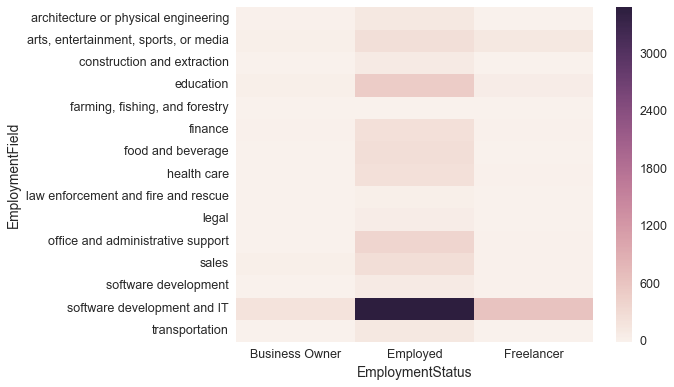

In [9]:
subset_df = df[['EmploymentField', 'EmploymentStatus']].copy(deep=True)
subset_df.replace({'Employed for wages': 'Employed',
                   'Self-employed business owner': 'Business Owner',
                   'Self-employed freelancer': 'Freelancer'}, inplace=True)
pvt = subset_df.pivot_table(index='EmploymentField', columns='EmploymentStatus', aggfunc=len).fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.heatmap(pvt)
plt.show()

<hr>

### Practicality of Bootcamps

One interesting question is whether coding "bootcamps" are useful as a tool for career advancement. Only a small fraction of the total sample population (~15K) responded as having attended a bootcamp.

In [10]:
finished_df = df[df['BootcampFinish'] == 1].copy(deep=True)
print 'People attended Bootcamp\t', len(df[df['AttendedBootcamp'] == 1])
print 'People finished Bootcamp\t', len(finished_df)

People attended Bootcamp	953
People finished Bootcamp	643


<br>
Filtering for the population that attended a bootcamp, we limit the data further to "popular" camps (where at least 10 people attended) and observe whether the attendees found a full-time job.

In [11]:
counts = df['BootcampName'].value_counts()
popular_camps = counts[counts >= 10].index
popular_camps = [camp for camp in popular_camps 
                 if not re.findall(r'Free Code Camp.*', camp)]

In [12]:
popular_df = finished_df[finished_df['BootcampName'].isin(popular_camps)]
job_df = pd.crosstab(index=popular_df['BootcampName'], 
                     columns=popular_df['BootcampFullJobAfter'],
                     colnames=['Job_Outcome'])

In [13]:
job_df.rename(columns={0.0: 'No', 1.0: 'Yes'}, inplace=True)
job_df['%FullJob'] = job_df['Yes'] / (job_df['No'] + job_df['Yes'])
job_df.sort_values(by='%FullJob', inplace=True, ascending=False)
job_df[:2]

Job_Outcome,No,Yes,%FullJob
BootcampName,,,
Hack Reactor,1,21,0.954545
Software Guild,1,8,0.888889


<br>
Merging the above with average post-bootcamp salaries yields a table that gives some sense of the results achieved by bootcamp attendees. There is no pre-bootcamp salary data, so unfortunately it is not possible to measure the effect of bootcamps on compensation.

To rank the results, we use a simple heuristic "score" by finding...

    ((mean of post-bootcamp salary) * (percent of bootcamp attendees who found a job)) 
    + 
    (0 - 10% of mean of all post-bootcamp salaries, weighted by successful outcomes)
    
... which could be interpreted as the expected value of post-bootcamp salary, with a little bonus based on relative sample size.

In [14]:
salary_df = popular_df[['BootcampName', 'BootcampPostSalary']].groupby('BootcampName').median()
merge_df = pd.merge(salary_df, job_df, left_index=True, right_index=True, how='outer')

# add scoring 
merge_df.dropna()
weight_bonus = (merge_df['Yes'] / max(merge_df['Yes']) * merge_df['BootcampPostSalary'].mean() * 0.1)
merge_df['Score'] = merge_df['BootcampPostSalary'] * merge_df['%FullJob'] + weight_bonus
merge_df.sort_values(by='Score', inplace=True, ascending=False)

# renaming and reformatting 
merge_df.rename(columns={'No': 'NoJobAfter', 'Yes':'YesJobAfter'}, inplace=True)
merge_df['BootcampPostSalary'] = merge_df['BootcampPostSalary'].apply(lambda x: '{:,.0f}'.format(x))
merge_df['Score'] = merge_df['Score'].apply(lambda x: '{:,.0f}'.format(x))
merge_df['%FullJob'] = merge_df['%FullJob'].apply(lambda x: '{:.0%}'.format(x))
merge_df[:10]

,BootcampPostSalary,NoJobAfter,YesJobAfter,%FullJob,Score
BootcampName,,,,,
Hack Reactor,"87,000",1,21,95%,"85,824"
App Academy,"90,000",5,13,72%,"66,720"
Turing,"70,000",1,6,86%,"60,794"
Hackbright Academy,"100,000",8,11,58%,"59,350"
Flatiron School,"75,000",9,24,73%,"57,721"
Dev Bootcamp,"70,000",9,28,76%,"56,678"
Launch Academy,"65,000",2,7,78%,"51,482"
Software Guild,"54,500",1,8,89%,"49,503"
General Assembly,"65,000",30,48,62%,"46,352"


<br>
Hack Reactor comes out on top, and indeed they appear to deliver the most consistent results when we look at the distribution of values using a boxplot below. There are some other reasonably well-performing options, but in general employment and salary outcomes appear to be highly variable. 

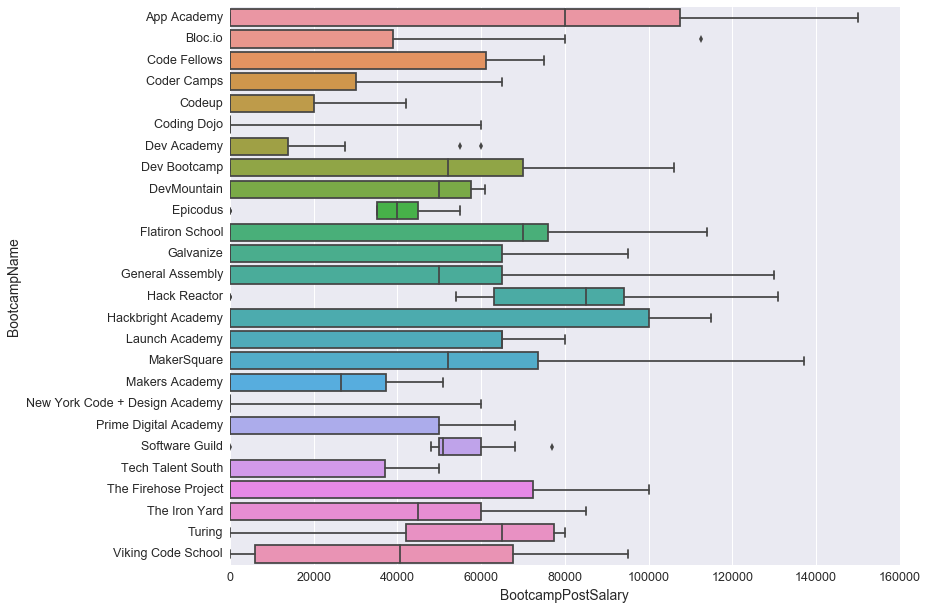

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

normalized = popular_df.fillna(0).sort_values(by='BootcampName')
normalized['BootcampPostSalary'] = normalized['BootcampPostSalary'].astype(float)
normalized['BootcampName'] = normalized['BootcampName'].apply(lambda x: str(x).decode('utf-8'))

sns.boxplot(x='BootcampPostSalary', y='BootcampName', data=normalized)
plt.show()

<hr>

### Most Common Resources / Podcasts

Using the data column trees from earlier, we can summarize the popular resources / podcasts according to the survey. The proliferation of coding podcasts remains limited, but there is an impressive array of programming resources that people appear to be using.

In [16]:
columns = ['Resource' + val for val in cols_tree['Resource']]
resource_df = df[columns]
resource_sum = resource_df.sum()
resource_sum.sort_values(ascending=False)[:10]

ResourceFCC            10937
ResourceCodecademy      9586
ResourceCoursera        4844
ResourceUdemy           4130
ResourceKhanAcademy     3746
ResourcePluralSight     3565
ResourceEdX             3472
ResourceUdacity         3306
ResourceOdinProj        1687
ResourceCodeWars        1563
dtype: float64

In [17]:
columns = ['Podcast' + val for val in cols_tree['Podcast']]
podcast_df = df[columns]
podcast_sum = podcast_df.sum()
podcast_sum.sort_values(ascending=False)[:10]

PodcastNone                    11040
PodcastCodeNewbie               1878
PodcastJSJabber                 1356
PodcastSEDaily                   775
PodcastChangeLog                 583
PodcastShopTalk                   83
PodcastDeveloperTea               80
PodcastRubyRogues                 79
PodcastTalkPython                 41
PodcastProgrammingThrowDown       34
dtype: float64